In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

spm = pd.read_csv('SPM/spm_results.csv', sep=',')
scc = pd.read_csv('SCC/scc_results.csv', sep=',')

assert (all(spm.columns == scc.columns))

data = pd.concat([spm, scc]);
data

,config,memorder,voting-strat,tpb,ipt,algorithm,problem_type,problem_size,runtime
0,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,2,0.96800005
1,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,4,14.787
2,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,6,1000.004
3,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,8,12585.703
4,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,10,non-zero exitcode.
...,...,...,...,...,...,...,...,...,...
1147,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.1,24814,0.42300004
1148,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.1,100095,0.65099996
1149,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.1,624033,non-zero exitcode.
1150,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.1,2500146,non-zero exitcode.


In [2]:
data = data.drop(data[data["runtime"] == "non-zero exitcode."].index)
data = data.drop(data[data["runtime"] == "NaN"].index)
data["runtime"] = data["runtime"].astype(float);
data["problem_size"] = data["problem_size"].astype(int);
data["ipt"] = data["ipt"].astype(int);
data["tpb"] = data["tpb"].astype(int);

data

,config,memorder,voting-strat,tpb,ipt,algorithm,problem_type,problem_size,runtime
0,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,2,0.968000
1,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,4,14.787000
2,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,6,1000.004000
3,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,8,12585.703000
6,relaxed-naive-512-4,relaxed,naive,512,4,SPM,invariantly_inevitably_eat,4,14.123001
...,...,...,...,...,...,...,...,...,...
1143,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.01,62582,0.681000
1144,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.01,250467,1.356000
1146,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.1,978,0.230000
1147,seqcons-naive-alternating-512-4,seqcons,naive-alternating,512,4,SCC_MP,random_0.1,24814,0.423000


In [3]:
""" Returns all rows with a configuration that is present
    for all possible values of variable_parameter, such that
    the only configuration-related difference between rows 
    is the variable_parameter.
"""
def get_comparable_rows(rows, variable_parameter):
    # Group rows by config, except for the variable_parameter
    config_cols = ["memorder", "voting-strat", "tpb", "ipt", "problem_size", "algorithm", "problem_type"];
    config_cols.remove(variable_parameter);
    
    # Compute all available variable_parameter options
    p_options = rows[variable_parameter].unique();
    
    # Per possible value of variable_parameter, get the corresponding rows
    rows_per_option = [rows[rows[variable_parameter] == opt] for opt in p_options];
    
    # Find the unique configs present per value of variable_parameter
    sets_of_configs = [set(r.groupby(config_cols).groups.keys()) for r in rows_per_option];
    
    # Get configs which are present for all possible values of variable_parameter
    shared_configs = list(reduce((lambda x, y : x & y), sets_of_configs));
    
    # Return all rows which have a shared config
    by_config = rows.groupby(config_cols);
    comp_rows = [];
    for (c, c_rows) in by_config:
        if c in shared_configs:
            comp_rows.append(c_rows);
    if comp_rows == []:
        print("WARNING: EMPTY ROWS TO COMPARE");
        return pd.DataFrame(data={});
    comparable_rows = pd.concat(comp_rows);
        
    return comparable_rows;


In [4]:
def bar_chart(rows, title, variable_parameter, ordering, logscale=True, xlabel="Problem size"):
    tot_width = 1.25;
    width = tot_width / len(ordering);
    assert (len(ordering) == len(rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    offset = - 0.5 * tot_width + 0.5 * width;
    rows = get_comparable_rows(rows, variable_parameter);
    ys = [];
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        Y = rows.groupby("problem_size")["runtime"].mean();
        ys.append(Y);
        plt.bar(Y.index + offset, Y.values, width=width, label=o);
        offset += width;
    plt.xlabel(xlabel);
    if logscale:
        plt.ylabel("Log runtime (ms)");
        plt.yscale("log");
    else:
        plt.ylabel("runtime (ms)");
        plt.yscale("log");
    plt.legend();
    plt.show();
    return ys;

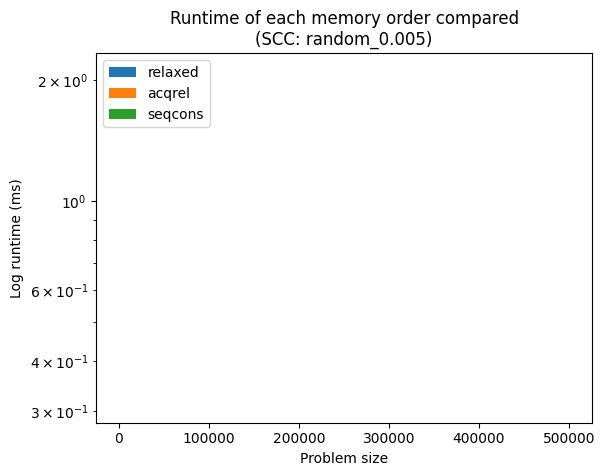

                              config memorder       voting-strat  tpb  ipt   
0     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4  \
1     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
2     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
3     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
18   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
..                               ...      ...                ...  ...  ...   
558  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
559  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
560  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
561  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
562  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   

    algorithm  problem_type  problem_size  runtime  
0         

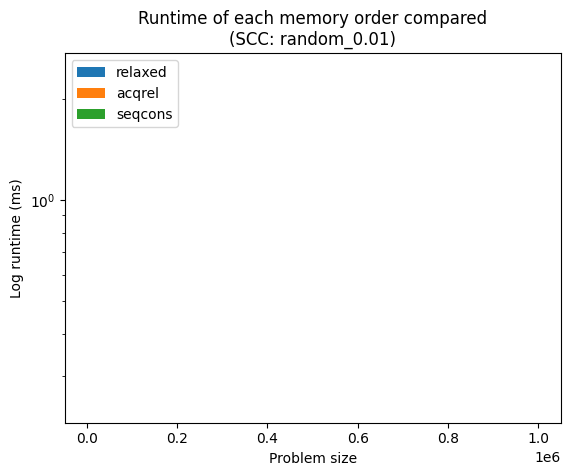

                              config memorder       voting-strat  tpb  ipt   
6     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4  \
7     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
8     acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
10    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
25   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
..                               ...      ...                ...  ...  ...   
564  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
565  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
566  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
567  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
568  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   

    algorithm problem_type  problem_size  runtime  
6         S

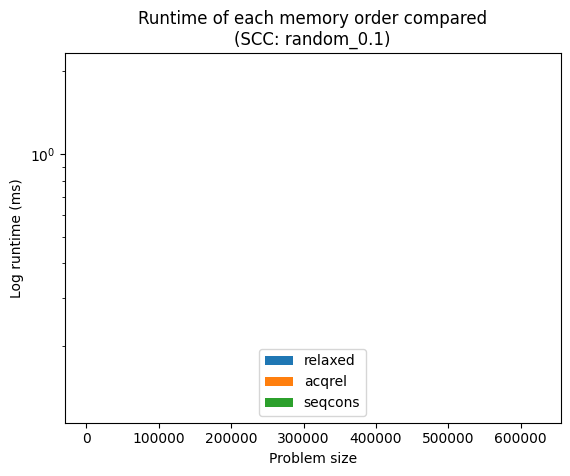

                              config memorder       voting-strat  tpb  ipt   
12    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4  \
13    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
30   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
31   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
32   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
..                               ...      ...                ...  ...  ...   
553  relaxed-naive-alternating-256-4  relaxed  naive-alternating  256    4   
554  relaxed-naive-alternating-256-4  relaxed  naive-alternating  256    4   
570  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
571  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
572  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   

    algorithm problem_type  problem_size  runtime  
12        S

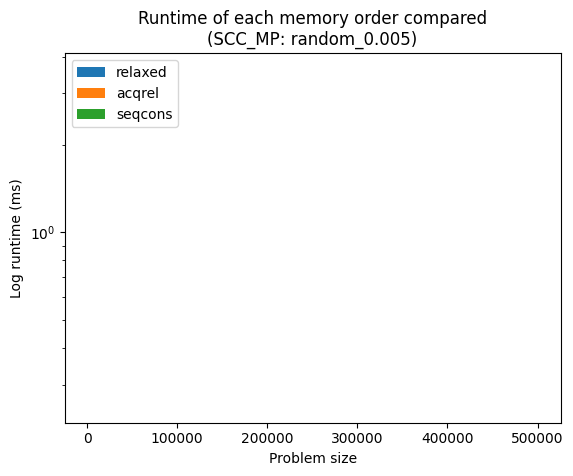

                               config memorder       voting-strat  tpb  ipt   
576    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4  \
577    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
578    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
579    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
580    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
...                               ...      ...                ...  ...  ...   
1134  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1135  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1136  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1137  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1138  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   

     algorithm  problem_type  problem_size  runtime

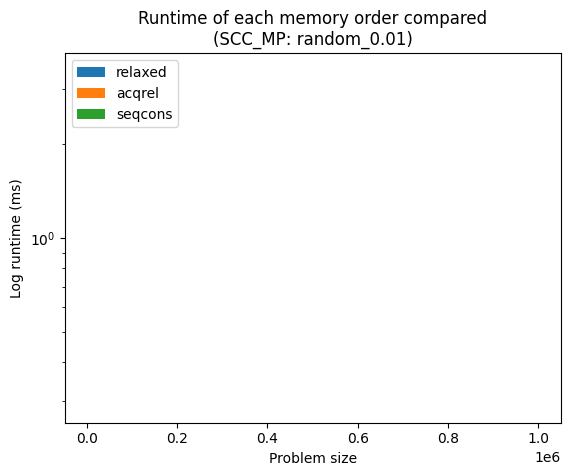

                               config memorder       voting-strat  tpb  ipt   
582    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4  \
583    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
584    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
585    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
586    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
...                               ...      ...                ...  ...  ...   
1140  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1141  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1142  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1143  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1144  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   

     algorithm problem_type  problem_size  runtime 

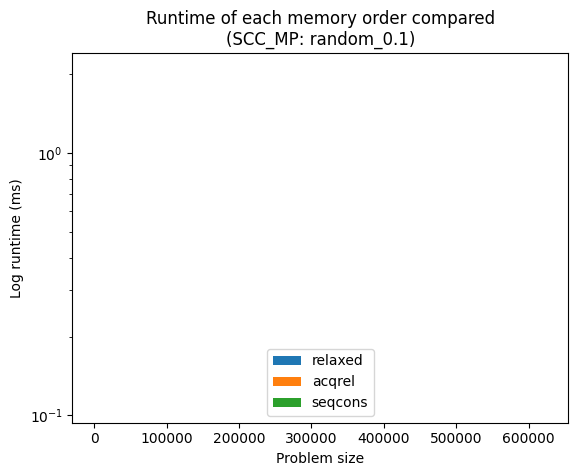

                               config memorder       voting-strat  tpb  ipt   
588    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4  \
589    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
590    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
606   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
607   relaxed-naive-alternating-64-16  relaxed  naive-alternating   64   16   
...                               ...      ...                ...  ...  ...   
1129  relaxed-naive-alternating-256-4  relaxed  naive-alternating  256    4   
1130  relaxed-naive-alternating-256-4  relaxed  naive-alternating  256    4   
1146  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1147  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   
1148  seqcons-naive-alternating-512-4  seqcons  naive-alternating  512    4   

     algorithm problem_type  problem_size  runtime 

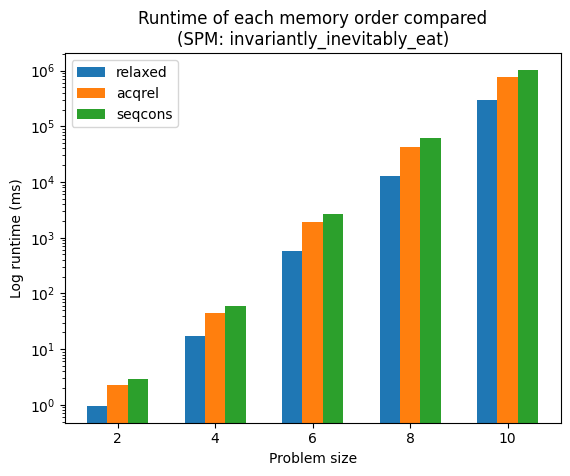

                               config memorder       voting-strat  tpb  ipt   
0    relaxed-naive-alternating-256-32  relaxed  naive-alternating  256   32  \
1    relaxed-naive-alternating-256-32  relaxed  naive-alternating  256   32   
2    relaxed-naive-alternating-256-32  relaxed  naive-alternating  256   32   
3    relaxed-naive-alternating-256-32  relaxed  naive-alternating  256   32   
6                 relaxed-naive-512-4  relaxed              naive  512    4   
..                                ...      ...                ...  ...  ...   
153   seqcons-naive-alternating-128-4  seqcons  naive-alternating  128    4   
155    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
156    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
157    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   
158    acqrel-naive-alternating-128-4   acqrel  naive-alternating  128    4   

    algorithm                problem_type  problem_

In [7]:
for alg, alg_rows in data.groupby("algorithm"):
    for p_type, p_type_rows in alg_rows.groupby("problem_type"):
        ys = bar_chart(
            p_type_rows,
            f"Runtime of each memory order compared\n({alg}: {p_type})",
            "memorder",
            ["relaxed", "acqrel", "seqcons"]
        );
        print(p_type_rows);
    
#         print(f"Seqcons/Rlx:");
#         print(ys[2]/ys[0]);

#         print(f"Seqcons/AcqRel:");
#         print(ys[2]/ys[1]);

#         print(f"AcqRel/Rlx:");
#         print(ys[1]/ys[0]);
    

In [6]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of each voting strategy compared\n(SPM: {f})",
        "voting-strat",
        ["naive-alternating", "naive"]
    );
    print(f"Naive/Naive-alternating:");
    print(ys[1]/ys[0]);

    
    

NameError: name 'per_formula' is not defined

In [ ]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of IPT compared\n(SPM: {f})",
        "ipt",
        [1, 4, 16, 32]
    );


In [ ]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of TPB compared\n(SPM: {f})",
        "tpb",
        [1024, 512, 256, 128, 64]
    );

In [ ]:
tot_width = 2;

for f, rows in per_formula:
    if f != "invariantly_inevitably_eat":
        continue;
        
    configs = rows.sort_values(by=['ipt'])["config"].unique();
    configs = [c for c in configs if c.startswith("relaxed")];
    width =  tot_width / len(configs);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    plt.figure(figsize=(15,8));
    plt.title(f"{f}")
    ys = [];
    for c in configs:
        c_rows = rows[rows["config"] == c];
        X = c_rows["problemsize"];
        Y = c_rows["runtime"];
        if c_rows["ipt"].iloc[0] == 1:
            h = '/';
        elif c_rows["ipt"].iloc[0] == 16:
            h = 'o';
        elif c_rows["ipt"].iloc[0] == 32:
            h = '*';
        else:
            h = '+';
        
        if c_rows["tpb"].iloc[0] == 128:
            a = 1;
        else:
            a = 0.3;
        
        plt.bar(X + offset, Y, width, label=c, hatch=h, alpha=a);
        offset += width;
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.xlabel("Problem size");
    plt.ylabel("Log runtime (ms)");
    plt.yscale("log");
    plt.show();
